In [4]:
import itertools

import mdshare
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [5]:
data_file_path: str = mdshare.fetch('alanine-dipeptide-3x250ns-heavy-atom-positions.npz', working_directory='data') # type: ignore

with np.load(data_file_path) as npz:
  data = [npz[file_name].astype(np.float32) for file_name in npz]

input_var_count = data[0].shape[1]

In [6]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, input_size: int, output_size: int):
    super().__init__()

    self.sequence = nn.Sequential(
      nn.Linear(input_size, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, output_size)
    )

  def forward(self, x):
    return self.sequence(x)

In [7]:
data[0].shape

(250000, 30)

In [69]:
trajectories = torch.tensor(np.array(data))

loader = DataLoader(TensorDataset(
  # torch.tensor(data[0][:-1]),
  # torch.tensor(data[0][1:]),

  torch.full((trajectories[0].size(0) - 1,), 0),
  torch.arange(trajectories[0].size(0) - 1)
), batch_size=128, shuffle=1)

# next(iter(loader))
# trajectories[0].size()

In [70]:
trajectories.size()

torch.Size([3, 250000, 30])

In [71]:
def distance(a: torch.Tensor, b: torch.Tensor):
  return (0.5 * (a - b) ** 2).sum(dim=-1)

def distance_neg(epsilon: float, a: torch.Tensor, b: torch.Tensor):
  return torch.relu(epsilon - distance(a, b))

latent_var_count = 10
background_step_count = 12

Z = FeedForwardNetwork(input_var_count, latent_var_count)
T = FeedForwardNetwork(latent_var_count, latent_var_count)

optimizer = torch.optim.SGD(itertools.chain(Z.parameters(), T.parameters()), lr=1e-5)
epoch_count = 1
losses = torch.zeros(epoch_count)

for epoch in range(epoch_count):
  epoch_loss = 0

  for traj_indices, step_indices in tqdm(loader):
    batch1 = trajectories[traj_indices, step_indices, :]
    batch2 = trajectories[traj_indices, step_indices + 1, :]

    s_neg = torch.stack([trajectories[traj_index, :, :][torch.randperm(trajectories.size(1) - 1)[:background_step_count] + torch.tensor([0, 1])[:, None], :] for traj_index in traj_indices])
    loss = (distance(Z(batch2), T(Z(batch1))) + distance_neg(3, Z(s_neg[:, 1, :, :]), T(Z(s_neg[:, 0, :, :]))).sum(dim=1)).mean()
    # loss = distance(Z(batch2), T(Z(batch1))).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  losses[epoch] = epoch_loss


100%|██████████| 1954/1954 [00:02<00:00, 862.11it/s]


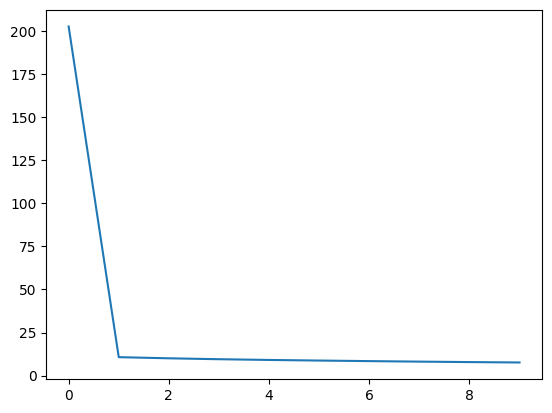

In [113]:
fig, ax = plt.subplots()

ax.plot(losses)

In [114]:
losses

tensor([202.6672,  10.6993,  10.0371,   9.5032,   9.0839,   8.7271,   8.4041,
          8.1060,   7.8399,   7.6121])